# Vitrify for the MNIST Dataset

## Imports

In [1]:
import os
import sys

# Untie local dependency
cwd = os.getcwd().split("/")
local_repo_path = "/".join(cwd[:-1])
sys.path.insert(0, local_repo_path)

from src.models.multi_layer_perceptron import MultiLayerPerceptron
from src.models.soft_decision_tree import SoftBinaryDecisionTree
from src.models.variational_autoencoder import VariationalAutoEncoder
from src.models.convolutional_dnn import ConvDNN
from src.data.make_dataset import load_data, join_data
from src.visualization.visualize import draw_tree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

Using TensorFlow backend.


## Get the MNIST data

In [2]:
# Load the data (To download data from scratch, set already_downloaded=False)
data = load_data(dataset="MNIST", already_downloaded=True)

# Get the number of input features
n_rows, n_cols = np.shape(data["x_train"])[1:]
n_features = n_rows * n_cols
n_classes = np.unique(data["y_train"]).shape[0]

Let's look at the structure of the data:

In [3]:
for key, array in data.items():
    print(key, " ==>", np.shape(array))

y_train_one_hot  ==> (50000, 10)
x_test_flat  ==> (10000, 784)
x_train  ==> (50000, 28, 28)
x_test  ==> (10000, 28, 28)
y_train  ==> (50000,)
y_test_one_hot  ==> (10000, 10)
y_test  ==> (10000,)
x_valid  ==> (10000, 28, 28)
y_valid  ==> (10000,)
y_valid_one_hot  ==> (10000, 10)
x_valid_flat  ==> (10000, 784)
x_train_flat  ==> (50000, 784)


Here, the **data** variable is a dictionary, consisting of numpy arrays. Above we can see the shapes of the MNIST data in our dictionary. We can also inspect the other variables we created above:

In [4]:
print("n_rows: ", n_rows)
print("n_cols: ", n_cols)
print("n_features: ", n_features)
print("n_classes: ", n_classes)

n_rows:  28
n_cols:  28
n_features:  784
n_classes:  10


Let's visualise the training data with their labels:

<Figure size 432x288 with 0 Axes>

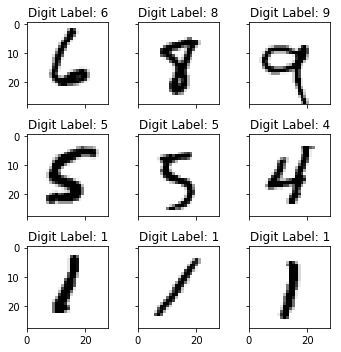

In [5]:
images_to_plot = 9
random_indices = np.random.choice(range(50000), images_to_plot)

sample_images = data["x_train_flat"][random_indices, :]
sample_labels = data["y_train"][random_indices]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_title("Digit Label: {}".format(sample_labels[i]))
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Thus, in summary, our training data (**"x_train"**) consists of 50000 28x28 images of handwritten images, with the labels saying what digit the image depicts (**"y_train"**). We also have a flattend version of the images (**"x_train_flat"**) and one-hot encoded labels (**"y_train_one_hot"**). This is the same for our validation and test data, both consisting of 10000 examples.

# Stage 1: Train the VAE

Start off by initialising the VAE model:

In [6]:
# Create VAE
vae = VariationalAutoEncoder(
    name = "vae",
    num_inputs = n_features,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = True,
    # Size of latent dimension
    latent_dim = 20,
    # Specify the encoder layers [units, activation, dropout, l2, bias]
    encoder_layers = [
        [512, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [128, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # Specify the decoder layers [units, activation, dropout, l2, bias]
    decoder_layers = [
        [128, "relu", 0.0, 0.0, True, "gaussian"],
        [256, "relu", 0.0, 0.0, True, "gaussian"],
        [512, "relu", 0.0, 0.0, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "sigmoid",
    # The maximum number of epochs to run
    epochs = 100,
    # The batch size to use in the VAE
    batch_size = 250,
    # The learning rate used in optimisation
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 10
)

Next, we train our model. By setting `load_model=True`, we load a previously trained model. If we want to train the VAE model from scratch, set `load_model=False`. The VAE does not receive any target data, seeing as it is not trying to predict the labels, but rather trying to reconstruct its input. Thus, we only pass the flattenend training and validation data to the model.

In [7]:
# Train VAE
vae.train(data["x_train_flat"], data["x_valid_flat"], load_model=True)

Loaded vae model from disk


In [8]:
# Evaluate VAE
vae_results = vae.evaluate(data["x_test_flat"])

accuracy: Nan | loss: 99.87088410644532


With our trained VAE model, we can generate new data. Here we generate 20000 additional data points:

In [9]:
# Generate new data
x_gen_flat = vae.sample(20000)
print(np.shape(x_gen_flat))

(20000, 784)


Lets visualise some results from our VAE model and the generated data:

<Figure size 432x288 with 0 Axes>

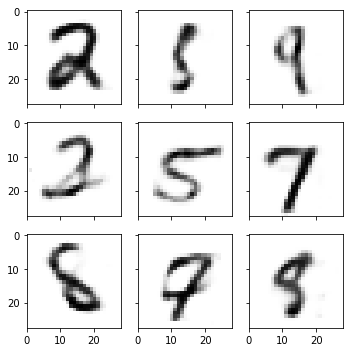

In [15]:
# Reshape to images
x_gen = np.array([np.reshape(x_gen_flat[i], [n_rows, n_cols]) for i in range(len(x_gen_flat))])

images_to_plot = 9
random_indices = np.random.choice(range(20000), images_to_plot)

sample_images = x_gen[random_indices, :]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

Here we can see some of the generated images from our VAE model. They are still unlabelled.

# Stage 2: Train the MLP and CNN

Start off by initialising the MLP model:

In [16]:
# Create MLP
mlp = MultiLayerPerceptron(
    name = "mlp",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"],
        [512, "relu", 0.0, 0.2, True, "gaussian"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

The same format as with the VAE applies, except here we provide the model with the necessary targets:

In [17]:
# Train MLP
mlp.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Loaded mlp model from disk


In [18]:
# Evaluate MLP
mlp_results = mlp.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 98.15% | loss: 0.08506726239238639


The MLP model achieved an accuracy of 98.15% on the test set. Next, we do the same for the CNN model:

In [21]:
# Create CNN
cnn = ConvDNN(
    name = "cnn",
    img_rows = n_rows,
    img_cols = n_cols,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Convolutional layers
    conv_layers = [
        # Layer, filters, kernel size, strides, padding, activation, use bias, kernel reg, bias reg, activity reg,
        # dropout (after layers)
        ["conv2d", 32, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        ["conv2d", 64, (3, 3), (1, 1), "valid", "relu", True, 0.0, 0.0, 0.0, 0.0],
        # Layer, pool size, stride, padding, dropout
        ["max_pool2d", (2, 2), None, "valid", 0.25],
    ],
    # ff_layers = [units, activation, regularization, dropout, use_bias]
    ff_layers = [
        [128, "relu", 0.0, 0.2, True, "normal"]
    ],
    # The final output layer's activation function
    final_activation = "softmax",
    # The objective function for the NN
    objective = "categorical_crossentropy",
    # The maximum number of epochs to run
    epochs = 20,
    # The batch size to use in the NN
    batch_size = 128,
    # The learning rate used in optimization
    learning_rate = 0.001,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

For the CNN model, we do not use the flattenend training data:

In [22]:
# Train CNN
cnn.train(
    data["x_train"], data["y_train_one_hot"],
    data["x_valid"], data["y_valid_one_hot"], load_model=True)

Loaded cnn model from disk


In [23]:
# Evaluate CNN
cnn_results = cnn.evaluate(data["x_test"], data["y_test_one_hot"])

accuracy: 99.21% | loss: 0.034443770900733604


The CNN model slightly outperformed the standard MLP model, achieving an accuracy of 99.21% on the test set.

# Stage 3: Produce soft targets for our interpretable model

We will now use our trained CNN model to:
1. Relabel our original training data, **x_train**
2. Give labels to our unlabelled, generated data, **x_gen**

In [24]:
# Get CNN labels
y_cnn_train = cnn.predict(data["x_train"])
y_gen = cnn.predict(x_gen)

Now we combine both the original training data and the generated data, as well as their new soft target labels, and shuffle them:

In [27]:
# Combine x_train and x_gen
x_both = join_data([data["x_train"], x_gen])

# Flatten them to use it with our interpretable model
x_both = x_both.reshape((x_both.shape[0], -1))

# Combine y_cnn_train and y_gen
y_both = join_data([y_cnn_train, y_gen])

# Shuffle the data
x_both, y_both = shuffle(x_both, y_both)

print("x_both ==>", np.shape(x_both))
print("y_both ==>", np.shape(y_both))

x_both ==> (70000, 784)
y_both ==> (70000, 10)


Thus, we have increased our training data from 50000 samples to 70000, where each sample now has a soft target produced from the CNN model, which we are going to approximate.

# Stage 4: Train our interpretable model, the SDT

For the sake of comparison, we will train three separate models:
1. SDT using only the original data with original hard targets.
2. SDT using only the original data with new soft targets (provided by the CNN in the third stage).
3. SDT using the generated and the original data with soft targets.

## 1) SDT using only the original data with original hard targets

In [28]:
# Create SDT
sdt_raw = SoftBinaryDecisionTree(
    name = "sdt_raw",
    num_inputs = n_features,
    num_outputs = n_classes,
    # If true, training info is outputted to stdout
    keras_verbose = False,
    # A summary of the NN is printed to stdout
    print_model_summary = False,
    # Hyperparameters
    max_depth = 4,
    penalty_strength = 1e+1,
    penalty_decay = 0.25,
    inv_temp = 0.01,
    ema_win_size = 1000,
    # The learning rate used in optimization
    learning_rate = 5e-03,
    epochs = 40,
    batch_size = 4,
    # If this many stagnant epochs are seen, stop training
    stopping_patience = 20
)

Hyperparameters:
- `max_depth`: the maximum depth of the tree in terms of its inner nodes. This excludes leaves.
- `penalty_strength`: regularisation penalty strength.
- `penalty_decay`: regularisation penalty decay as a function of depth.
- `inv_temp`: scale the logits of the inner nodes to avoid very soft decisions.
- `ema_win_size`: scaling factor to the default size of the window used to calculate moving averages (growing exponentially with depth) of node and path probabilities.
- `batch_size`: we use a small one, because with increasing depth and thus a large amount of leaf bigots, larger batch sizes cause their loss terms to be scaled down too much by averaging, which results in poor optimisation properties. 

In [29]:
# Train SDT RAW
sdt_raw.train(
    data["x_train_flat"], data["y_train_one_hot"],
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_raw/sdt_raw
Loaded sdt_raw model from disk


In [30]:
# Evaluate SDT RAW
sdt_raw_results = sdt_raw.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 78.88% | loss: 17.66646990509033


The accuracy of our trained SDT on the original data and labels is 78.88%.

## 2) SDT using only the original data with new soft targets (provided by the CNN in the third stage)

In [31]:
# Create SDT CNN
sdt_cnn = SoftBinaryDecisionTree(
    name = "sdt_cnn",
    num_inputs = n_features,
    num_outputs = n_classes
)

Note that although the model parameters are hidden in the implementation above, they are the same as the first SDT. We now train this model with the soft targets from the CNN, but still use the hard targets in validation and testing.

In [32]:
# Train SDT CNN
sdt_cnn.train(
    data["x_train_flat"], y_cnn_train,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
INFO:tensorflow:Restoring parameters from /home/zander/thesis/vitrify/models/sdt_cnn/sdt_cnn
Loaded sdt_cnn model from disk


In [33]:
# Evaluate SDT CNN
sdt_cnn_results = sdt_cnn.evaluate(data["x_test_flat"], data["y_test_one_hot"])

accuracy: 90.94% | loss: 8.524234577941895


By using the soft targets, we increased the accuracy of our interpretable SDT from 78.88% to 90.94%.

## 3) SDT using the generated and the original data with soft targets

In [34]:
# Create SDT VAE
sdt_vae = SoftBinaryDecisionTree(
    name = "sdt_cnn_vae",
    num_inputs = n_features,
    num_outputs = n_classes
)

In [35]:
# Train SDT MLP
sdt_vae.train(
    x_both, y_both,
    data["x_valid_flat"], data["y_valid_one_hot"], load_model=True)

Built tree has 16 leaves out of 31 nodes
No saved model found. Check file name or train from scratch
